In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'bull phase CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Bull Phase Stock Data

bull phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2002-10-07        17.00  19.847770 -84.169452 -28567700.0     2.0
2002-10-08        15.92  19.243497 -95.667449 -31364300.0     2.0
2002-10-09        17.40  18.959882 -77.411483 -28566500.0     2.0
2002-10-10        17.01  18.659901 -82.173381 -30113300.0     1.0
2002-10-11        15.57  18.184531 -92.376119 -34697400.0     2.0


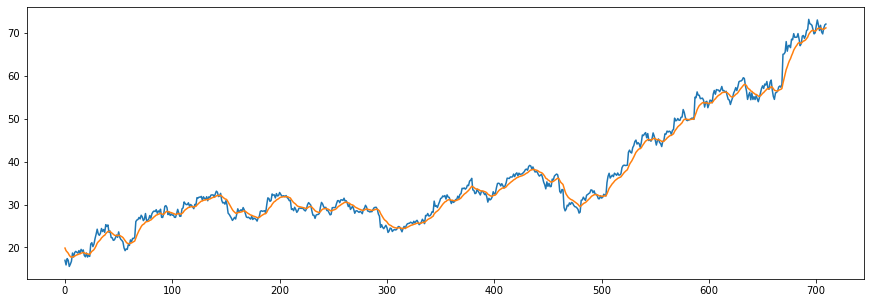

bull phase data\1_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2012-05-29    70.000000  71.826248 -83.958021  76061900.0     2.0
2012-05-30    70.400002  71.606826 -76.058610  80035500.0     2.0
2012-05-31    69.389999  71.265775 -92.508157  75357900.0     2.0
2012-06-01    69.610001  71.011041 -86.872582  79549300.0     1.0
2012-06-04    67.239998  70.430880 -98.496264  73957300.0     2.0


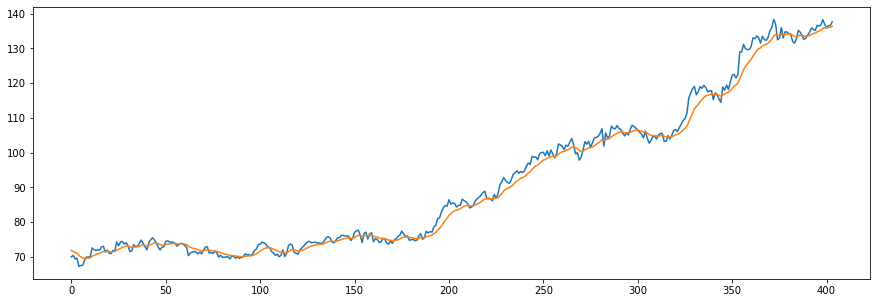

bull phase data\2_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2015-09-21    17.299999  17.431825 -56.565680  1.278304e+10     2.0
2015-09-22    17.320000  17.414621 -55.892264  1.279559e+10     2.0
2015-09-23    17.389999  17.410833 -59.550566  1.281234e+10     2.0
2015-09-24    16.549999  17.278397 -94.921907  1.278454e+10     2.0
2015-09-25    16.600000  17.174028 -92.968737  1.279631e+10     2.0


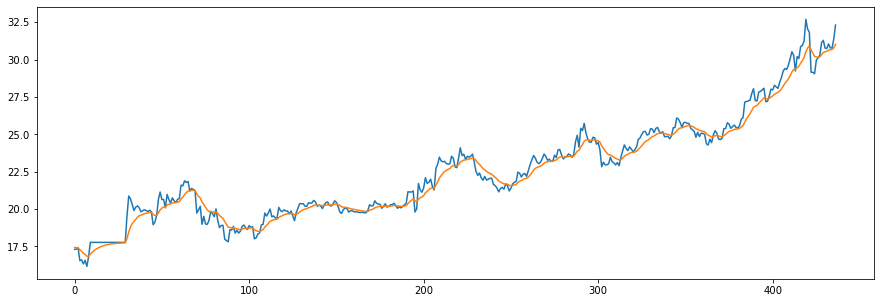

bull phase data\3_acc_data.csv
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2016-08-01         8.60  8.822459 -95.454447  221939090.0     2.0
2016-08-02         8.66  8.797466 -81.818221  229749090.0     2.0
2016-08-03         8.59  8.765548 -91.489375  223312390.0     2.0
2016-08-04         8.35  8.701618 -93.055532  213631195.0     1.0
2016-08-05         8.31  8.641369 -95.945857  207289495.0     2.0


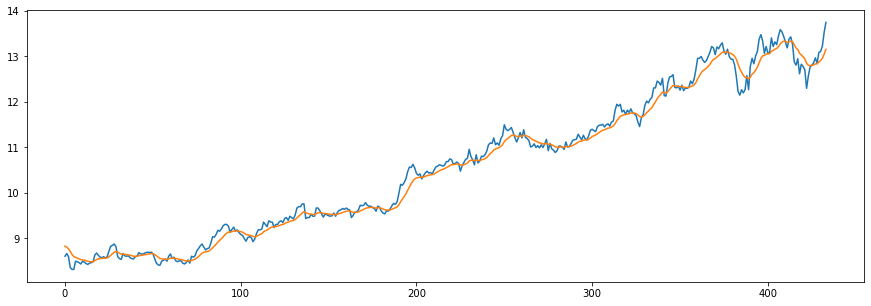

bull phase data\4_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2012-05-29    33.500000  35.391902 -87.056352 -2.715978e+09     2.0
2012-05-30    33.630001  35.120840 -85.010916 -2.680123e+09     2.0
2012-05-31    32.959999  34.788403 -92.341351 -2.714327e+09     2.0
2012-06-01    33.150002  34.536341 -84.467667 -2.672202e+09     2.0
2012-06-04    31.930000  34.135366 -97.090912 -2.722674e+09     1.0


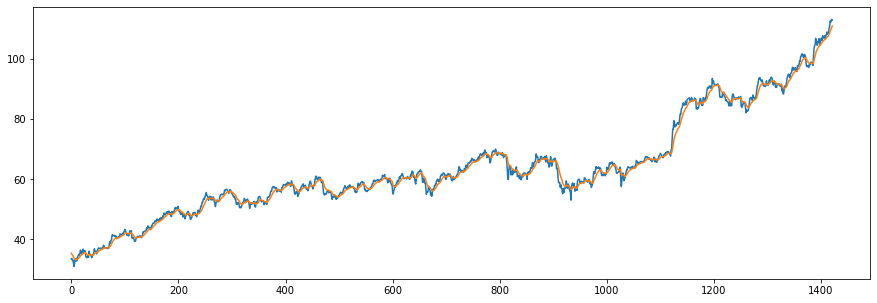

bull phase data\5_acc_data.csv
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-06-30        2.575  2.436754 -19.047606  495757896.0     2.0
2004-07-01        2.525  2.450330 -33.333298  480565876.0     2.0
2004-07-02        2.525  2.461818 -33.333298  480565876.0     2.0
2004-07-05        2.550  2.475385 -27.777775  505227876.0     2.0
2004-07-06        2.550  2.486864 -27.777775  505227876.0     2.0


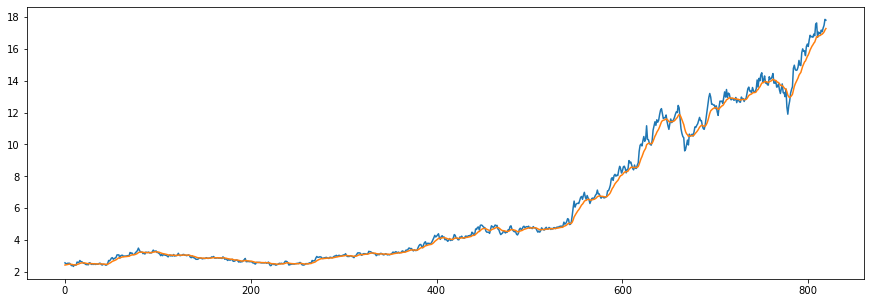

In [5]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

for filepath in glob.iglob('bull phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

In [6]:
willr_data = np.array(willr_data)
willr_data.shape

(4143, 15, 1)

In [7]:
price_data = np.array(price_data)
price_data.shape

(4143, 15, 1)

In [8]:
ema_data = np.array(ema_data)
ema_data.shape

(4143, 15, 1)

In [9]:
obv_data = np.array(obv_data)
obv_data.shape

(4143, 15, 1)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [11]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4143, 64, 64, 1)

In [12]:
from collections import Counter

Counter(y)

Counter({0.0: 185, 2.0: 3780, 1.0: 178})

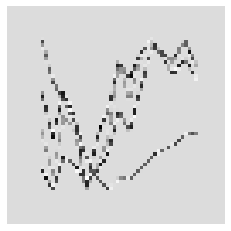

In [13]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [14]:
X = X/255

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.463963963963964, 1: 7.779342723004695, 2: 0.36529982363315694}
Epoch 1/200
 1/26 [>.............................] - ETA: 0s - loss: 0.3643 - accuracy: 0.6875 - mse: 5.4590 - weighted_accuracy: 0.5127 - weighted_mse: 5.9962WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 27ms/step - loss: 0.2512 - accuracy: 0.3274 - mse: 1.7493 - weighted_accuracy: 0.3318 - weighted_mse: 1.7934 - val_loss: 0.2209 - val_accuracy: 0.0483 - val_mse: 0.8467 - val_weighted_accuracy: 0.0483 - val_weighted_mse: 0.8467
Epoch 2/200
26/26 [==============================] - 0s 10ms/step - loss: 0.2051 - accuracy: 0.3325 - mse: 1.1923 - weighted_accuracy: 0.3569 - weighted_mse: 1.1934 - val_loss: 0.1946 - val_accuracy: 0.4548 - v

Epoch 27/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1962 - accuracy: 0.3509 - mse: 1.1563 - weighted_accuracy: 0.3780 - weighted_mse: 1.1644 - val_loss: 0.1987 - val_accuracy: 0.0736 - val_mse: 0.9271 - val_weighted_accuracy: 0.0736 - val_weighted_mse: 0.9271
Epoch 28/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1958 - accuracy: 0.3739 - mse: 1.1903 - weighted_accuracy: 0.4175 - weighted_mse: 1.1831 - val_loss: 0.1973 - val_accuracy: 0.0953 - val_mse: 0.9263 - val_weighted_accuracy: 0.0953 - val_weighted_mse: 0.9263
Epoch 29/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1957 - accuracy: 0.3537 - mse: 1.1773 - weighted_accuracy: 0.3822 - weighted_mse: 1.1816 - val_loss: 0.1884 - val_accuracy: 0.4644 - val_mse: 1.0036 - val_weighted_accuracy: 0.4644 - val_weighted_mse: 1.0036
Epoch 30/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1955 - accuracy: 0.3458 - mse: 1.1970 - weighted_accuracy: 0.3956 - w

Epoch 56/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1826 - accuracy: 0.2767 - mse: 1.2380 - weighted_accuracy: 0.5007 - weighted_mse: 1.2076 - val_loss: 0.1920 - val_accuracy: 0.2400 - val_mse: 1.0393 - val_weighted_accuracy: 0.2400 - val_weighted_mse: 1.0393
Epoch 57/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1778 - accuracy: 0.2474 - mse: 1.2678 - weighted_accuracy: 0.5159 - weighted_mse: 1.2295 - val_loss: 0.1922 - val_accuracy: 0.1737 - val_mse: 1.0561 - val_weighted_accuracy: 0.1737 - val_weighted_mse: 1.0561
Epoch 58/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1821 - accuracy: 0.2550 - mse: 1.2891 - weighted_accuracy: 0.4856 - weighted_mse: 1.2532 - val_loss: 0.1970 - val_accuracy: 0.1194 - val_mse: 0.9855 - val_weighted_accuracy: 0.1194 - val_weighted_mse: 0.9855
Epoch 59/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1790 - accuracy: 0.2468 - mse: 1.2195 - weighted_accuracy: 0.5130 - w

Epoch 85/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1618 - accuracy: 0.2568 - mse: 1.3682 - weighted_accuracy: 0.5777 - weighted_mse: 1.3544 - val_loss: 0.1893 - val_accuracy: 0.2183 - val_mse: 1.2105 - val_weighted_accuracy: 0.2183 - val_weighted_mse: 1.2105
Epoch 86/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1617 - accuracy: 0.2444 - mse: 1.3801 - weighted_accuracy: 0.5599 - weighted_mse: 1.3676 - val_loss: 0.1919 - val_accuracy: 0.2581 - val_mse: 1.1363 - val_weighted_accuracy: 0.2581 - val_weighted_mse: 1.1363
Epoch 87/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1597 - accuracy: 0.2580 - mse: 1.3944 - weighted_accuracy: 0.5846 - weighted_mse: 1.3815 - val_loss: 0.1897 - val_accuracy: 0.1677 - val_mse: 1.3448 - val_weighted_accuracy: 0.1677 - val_weighted_mse: 1.3448
Epoch 88/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1607 - accuracy: 0.2698 - mse: 1.3449 - weighted_accuracy: 0.5677 - w

Epoch 114/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1398 - accuracy: 0.3476 - mse: 1.5869 - weighted_accuracy: 0.6771 - weighted_mse: 1.6289 - val_loss: 0.1788 - val_accuracy: 0.3969 - val_mse: 1.4014 - val_weighted_accuracy: 0.3969 - val_weighted_mse: 1.4014
Epoch 115/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1378 - accuracy: 0.3654 - mse: 1.5891 - weighted_accuracy: 0.6859 - weighted_mse: 1.6431 - val_loss: 0.1917 - val_accuracy: 0.3076 - val_mse: 1.5482 - val_weighted_accuracy: 0.3076 - val_weighted_mse: 1.5482
Epoch 116/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1377 - accuracy: 0.3509 - mse: 1.6421 - weighted_accuracy: 0.6807 - weighted_mse: 1.6654 - val_loss: 0.1869 - val_accuracy: 0.3390 - val_mse: 1.4092 - val_weighted_accuracy: 0.3390 - val_weighted_mse: 1.4092
Epoch 117/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1354 - accuracy: 0.3841 - mse: 1.6269 - weighted_accuracy: 0.692

Epoch 143/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1192 - accuracy: 0.5284 - mse: 1.8694 - weighted_accuracy: 0.7439 - weighted_mse: 2.1234 - val_loss: 0.1728 - val_accuracy: 0.4946 - val_mse: 1.5892 - val_weighted_accuracy: 0.4946 - val_weighted_mse: 1.5892
Epoch 144/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1184 - accuracy: 0.5015 - mse: 1.8759 - weighted_accuracy: 0.7468 - weighted_mse: 2.1219 - val_loss: 0.1633 - val_accuracy: 0.5537 - val_mse: 1.5838 - val_weighted_accuracy: 0.5537 - val_weighted_mse: 1.5838
Epoch 145/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1231 - accuracy: 0.5428 - mse: 1.8389 - weighted_accuracy: 0.7471 - weighted_mse: 2.0191 - val_loss: 0.1742 - val_accuracy: 0.4873 - val_mse: 1.6367 - val_weighted_accuracy: 0.4873 - val_weighted_mse: 1.6367
Epoch 146/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1179 - accuracy: 0.5241 - mse: 1.8859 - weighted_accuracy: 0.7465 

Epoch 172/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1053 - accuracy: 0.6273 - mse: 2.1401 - weighted_accuracy: 0.7824 - weighted_mse: 2.6541 - val_loss: 0.1412 - val_accuracy: 0.7081 - val_mse: 1.7085 - val_weighted_accuracy: 0.7081 - val_weighted_mse: 1.7085
Epoch 173/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1072 - accuracy: 0.6113 - mse: 2.1895 - weighted_accuracy: 0.7635 - weighted_mse: 2.6919 - val_loss: 0.1391 - val_accuracy: 0.7274 - val_mse: 1.7332 - val_weighted_accuracy: 0.7274 - val_weighted_mse: 1.7332
Epoch 174/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1060 - accuracy: 0.6331 - mse: 2.2001 - weighted_accuracy: 0.7801 - weighted_mse: 2.7408 - val_loss: 0.1440 - val_accuracy: 0.6984 - val_mse: 1.7016 - val_weighted_accuracy: 0.6984 - val_weighted_mse: 1.7016
Epoch 175/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1044 - accuracy: 0.6316 - mse: 2.1316 - weighted_accuracy: 0.785

In [20]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13005377352237701
Test accuracy: 0.7466827630996704


In [21]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.0174446  -1.476545    0.0347425 ]
 [-1.0358768  -1.3286207   0.00754774]
 [-1.1656395  -1.1052775  -0.04340418]
 ...
 [-0.65163535 -2.1545813  -0.17301641]
 [-0.91722417 -1.2702112  -0.05852343]
 [-0.9763341  -1.459426    0.02049951]]


Counter({2: 673, 1: 66, 0: 90})

In [22]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 756, 1: 36, 0: 37})

In [23]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 829
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 31
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 32
actual holds but predicted buy: 62
actual holds but predicted sell: 84
actual predicted holds: 610
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 13.513513513513514%
Percentage holds correct: 80.68783068783068%
actual buys: 36
actual sells: 37
actual holds: 756


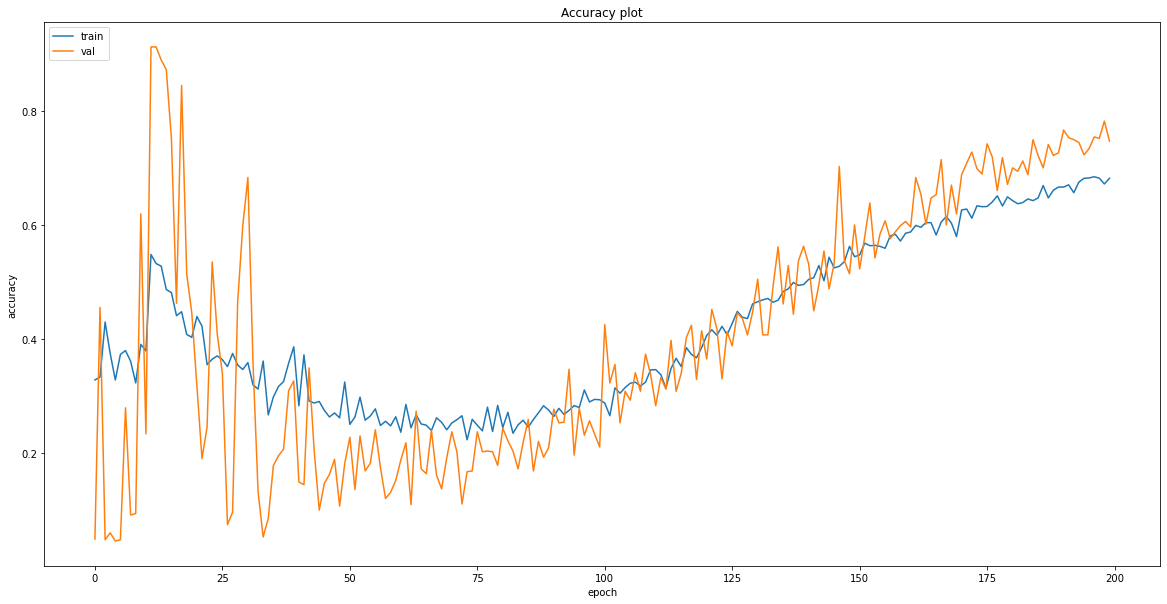

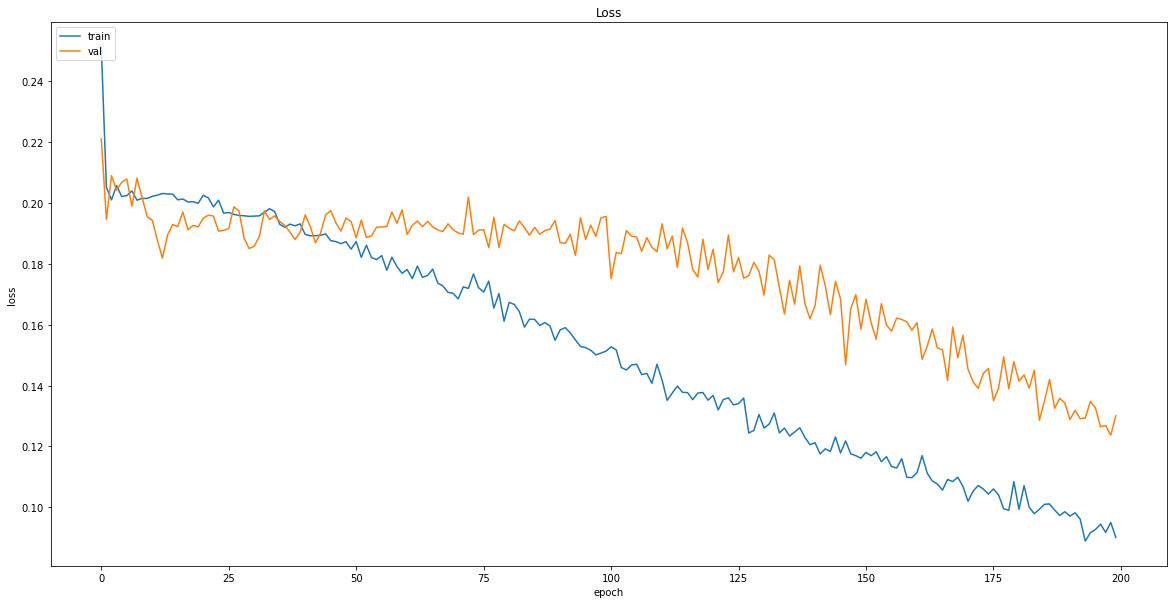

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Save model
model.save("models/{}".format('bull_phase_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/bull_phase_image_cnn_buy_hold_sell.model\assets


### Test Performance

### Accumulation Test Data

In [26]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [27]:
seed = 10
df = pd.read_csv("accumulation phase data/test_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2004-06-14,93.010002,92.918784,-32.009897,48922600.0,2.0
2004-06-15,91.529999,92.705124,-68.734488,45879300.0,2.0
2004-06-16,90.209999,92.321259,-94.676024,40369000.0,2.0
2004-06-17,89.980003,91.961066,-87.983635,36219100.0,2.0
2004-06-18,89.339996,91.557824,-85.961924,32718400.0,2.0


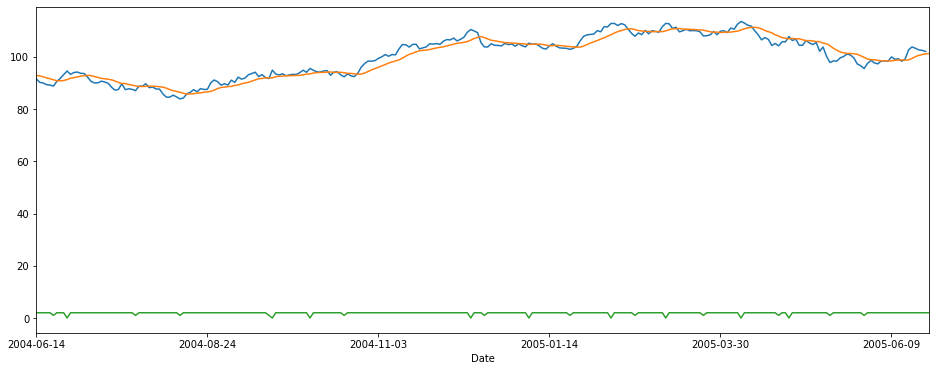

In [28]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [29]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [30]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [31]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [33]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [34]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [35]:
model = tf.keras.models.load_model("models/bull_phase_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

8/8 [==============================] - 0s 6ms/step - loss: 0.1232 - accuracy: 0.7823 - mean_squared_error: 1.8458 - weighted_accuracy: 0.7823 - weighted_mean_squared_error: 1.8458
Test loss: 0.12319468706846237
Test accuracy: 0.7822580933570862


In [36]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 206, 1: 21, 0: 21})

In [37]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 229, 1: 11, 0: 8})

In [38]:
df = pd.read_csv("accumulation phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [39]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2004-07-02,93.610001,92.761151,-20.080318,52187800.0,2.0,2,2
2004-07-06,92.199997,92.891743,-20.615805,48857200.0,2.0,2,2
2004-07-07,90.570000,92.785321,-39.491353,46253500.0,2.0,2,2
2004-07-08,90.000000,92.444502,-61.311929,41751600.0,2.0,2,2
2004-07-09,90.050003,92.068425,-68.942446,38258400.0,2.0,2,2


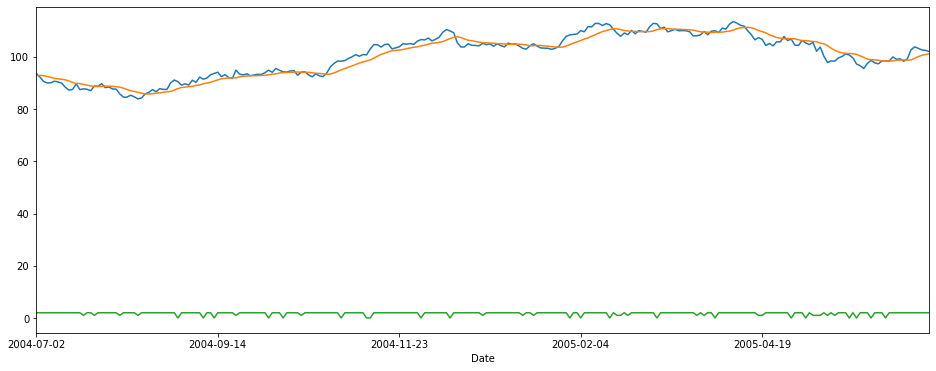

In [40]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

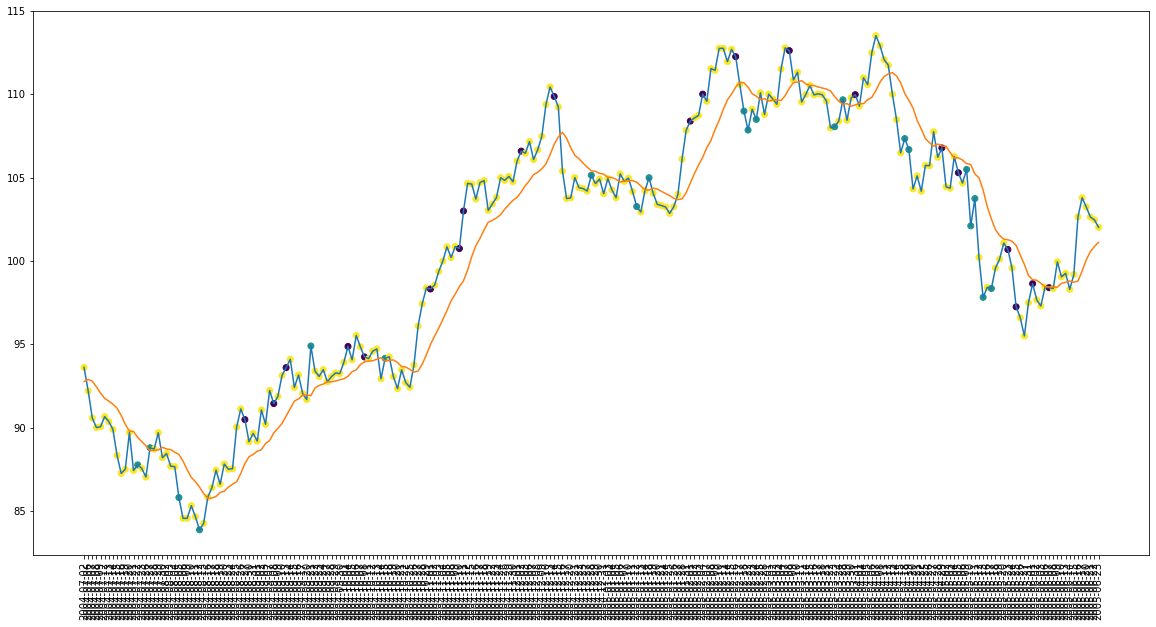

In [41]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

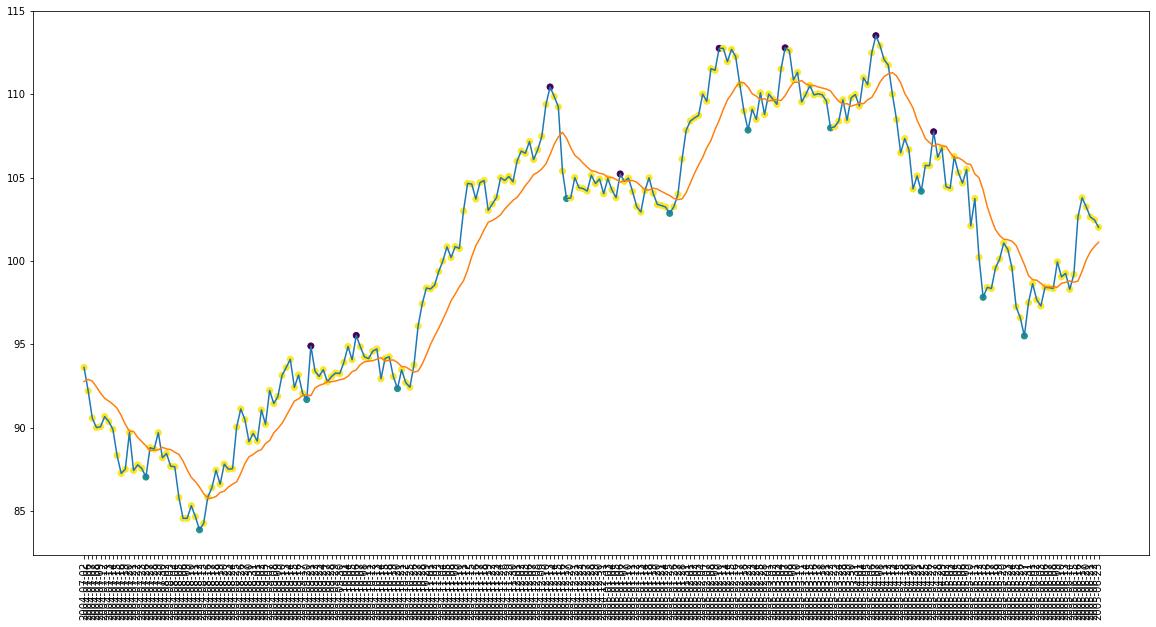

In [42]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [43]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 248
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 17
actual holds but predicted sell: 21
actual predicted holds: 191
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 0.0%
Percentage holds correct: 83.4061135371179%
actual buys: 11
actual sells: 8
actual holds: 229


In [44]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[88.33000183105469, 89.88999938964844, 90.0, 90.05000305175781, 90.36000061035156, 90.56999969482422, 90.66000366210938, 92.1999969482422, 93.61000061035156]
[87.25, 87.41999816894531, 87.5, 87.55000305175781, 87.76000213623047, 88.33000183105469, 89.69999694824219, 89.88999938964844, 90.36000061035156]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 61.904761904761905%
Percentage holds correct: 83.41463414634147%


In [45]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $87.76000213623047
Shares owned at the moment: 113
Cash capital at the moment: $55.84833794212318


Stop Loss Activated!

Share price: $84.55000305175781
Shares owned at the moment: 0
Cash capital at the moment: $9583.724769342421


Share price: $83.86000061035156
Shares owned at the moment: 113
Cash capital at the moment: $81.48520518302757


Price increase from previously bought: 7.598217349700898%
Share price: $90.4800033569336
Shares owned at the moment: 0
Cash capital at the moment: $10277.608923473355


Share price: $94.9000015258789
Shares owned at the moment: 108
Cash capital at the moment: $0.22345822524766845


Price increase from previously bought: 5.873230470852242%
Share price: $100.75
Shares owned at the moment: 0
Cash capital at the moment: $10851.300708225248


Share price: $105.1500015258789
Shares owned at the moment: 102
Cash capital at the moment: $96.50597715759068


Price increase from previously bought: 6.478458621924332%
Share price: $112.2699966430

In [46]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10834.4334352684
profit gained: 8.344334352684001%


In [47]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.782258,27.272727272727273%,0.0%,83.4061135371179%,42.857142857142854%,61.904761904761905%,83.41463414634147%,4.304738879795023%,8.344334352684001%


### Mark-up phase test data

In [48]:
logger = []

In [49]:
seed = 10
df = pd.read_csv("mark up phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


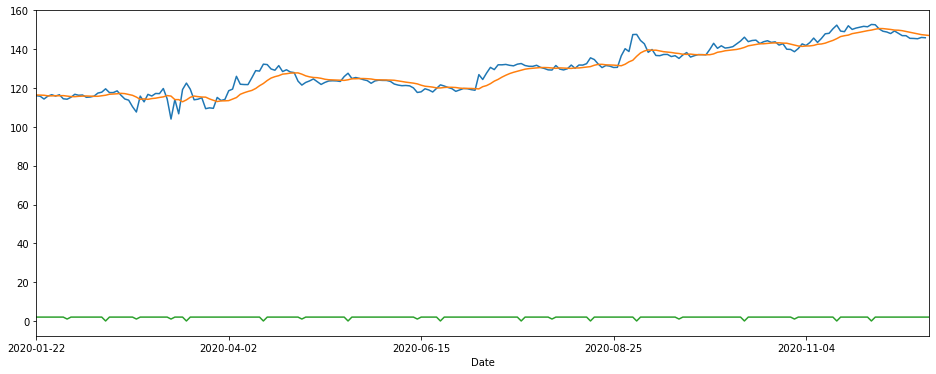

In [50]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [51]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [52]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [54]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [55]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [56]:
model = tf.keras.models.load_model("models/bull_phase_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1253 - accuracy: 0.7717 - mean_squared_error: 1.8480 - weighted_accuracy: 0.7717 - weighted_mean_squared_error: 1.8480
Test loss: 0.12528985738754272
Test accuracy: 0.7716894745826721


In [57]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 179, 0: 17, 1: 23})

In [58]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [59]:
df = pd.read_csv("mark up phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [60]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,0,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


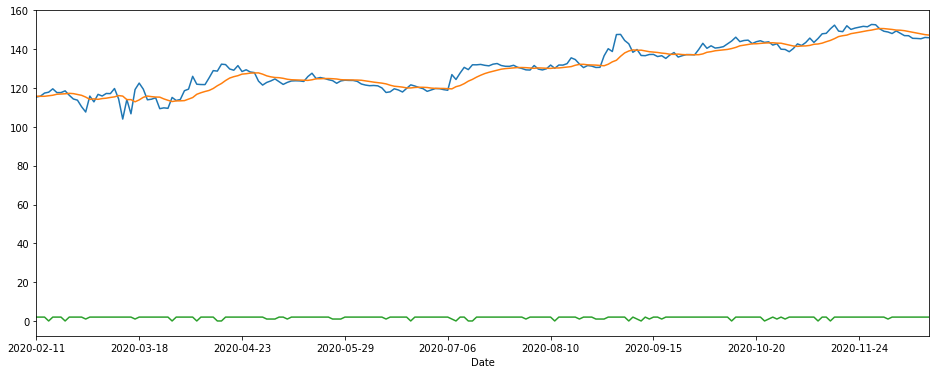

In [61]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

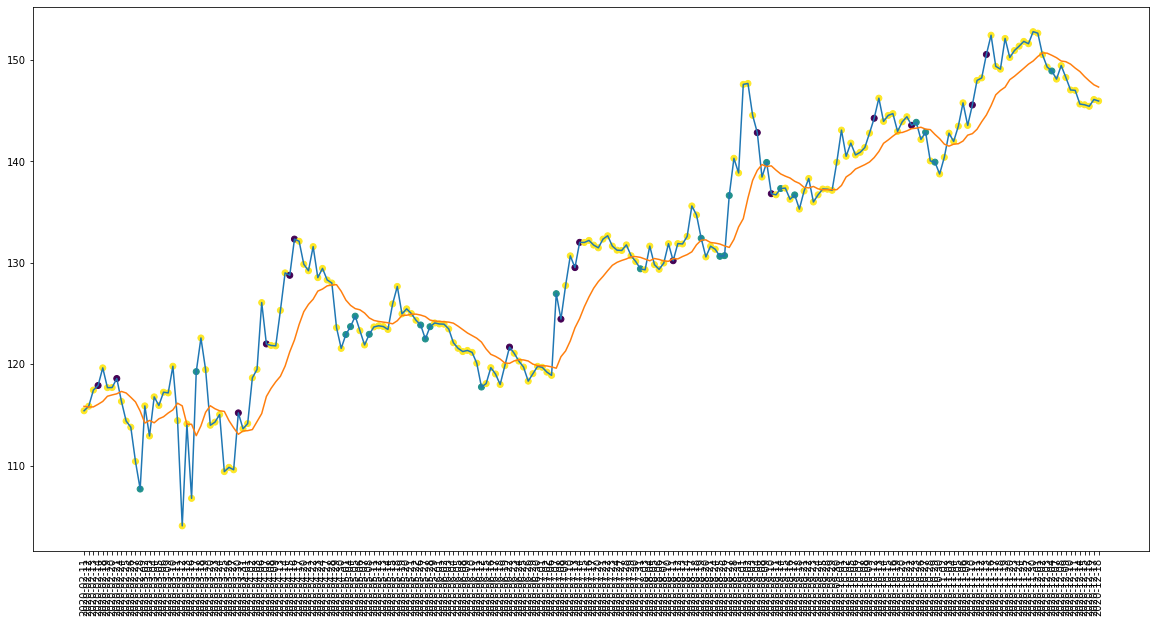

In [62]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

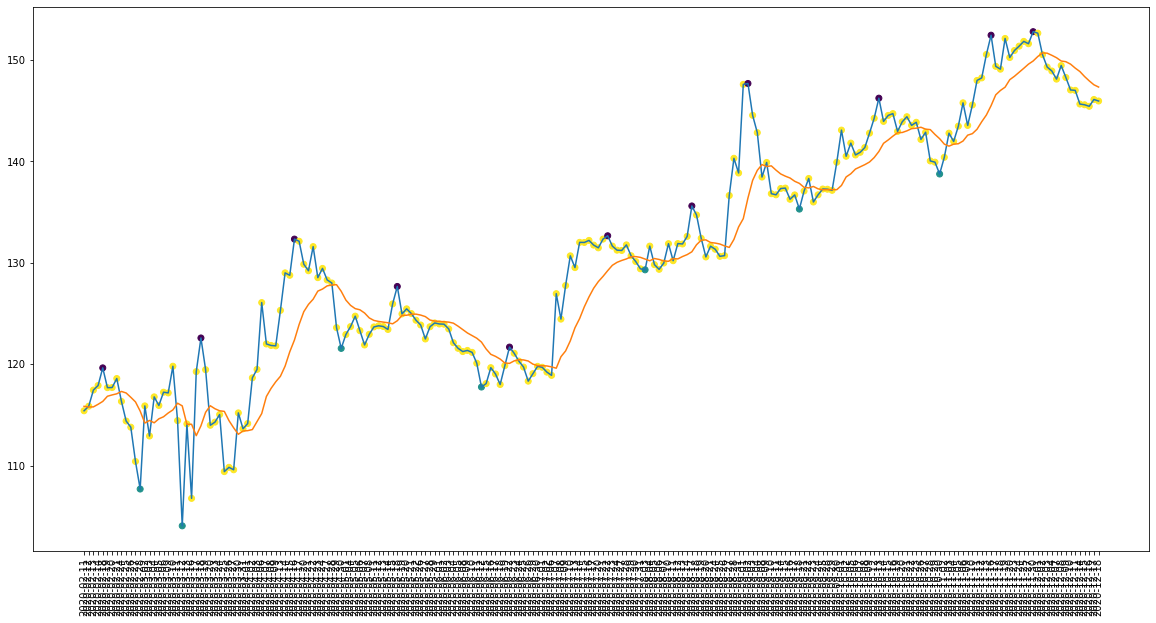

In [63]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [64]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 21
actual holds but predicted sell: 15
actual predicted holds: 165
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 82.08955223880596%
actual buys: 7
actual sells: 11
actual holds: 201


In [65]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 56.52173913043478%
Percentage sells correct: 58.8235294117647%
Percentage holds correct: 85.3932584269663%


In [66]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $107.68000030517578
Shares owned at the moment: 92
Cash capital at the moment: $66.1969318466181


Stop Loss Activated!

Share price: $104.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $9612.47256183624


Share price: $119.26000213623048
Shares owned at the moment: 80
Cash capital at the moment: $45.43519046782967


Stop Loss Activated!

Share price: $113.97000122070312
Shares owned at the moment: 0
Cash capital at the moment: $9137.961887855525


Share price: $122.91999816894531
Shares owned at the moment: 74
Cash capital at the moment: $16.867803726190687


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $8705.667556079858


Share price: $117.73999786376952
Shares owned at the moment: 73
Cash capital at the moment: $87.01140745353223


Price increase from previously bought: 5.400656686721583%
Share price: $124.44000244140624
Shares owned at the moment: 0
Cash capital at the moment:

In [67]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


In [68]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.782258,27.272727272727273%,0.0%,83.4061135371179%,42.857142857142854%,61.904761904761905%,83.41463414634147%,4.304738879795023%,8.344334352684001%
1,0.771689,28.571428571428573%,18.181818181818183%,82.08955223880596%,56.52173913043478%,58.8235294117647%,85.3932584269663%,-9.681691407947637%,25.65490331684112%


### Distribution Phase Test Data

In [69]:
logger = []

In [70]:
seed = 10
df = pd.read_csv("distribution phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2016-12-05   223.360001  213.378658 -16.514565 -283274800.0     2.0
2016-12-06   228.550003  215.712711  -2.667189 -278675500.0     2.0
2016-12-07   231.380005  218.123064  -4.633597 -273416200.0     2.0
2016-12-08   235.559998  220.805669  -1.742271 -266821000.0     2.0
2016-12-09   241.449997  223.981719  -2.918174 -259477300.0     2.0


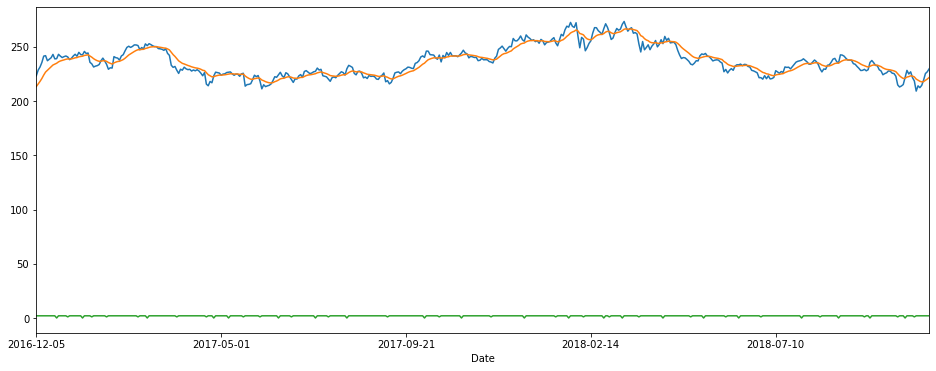

In [71]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

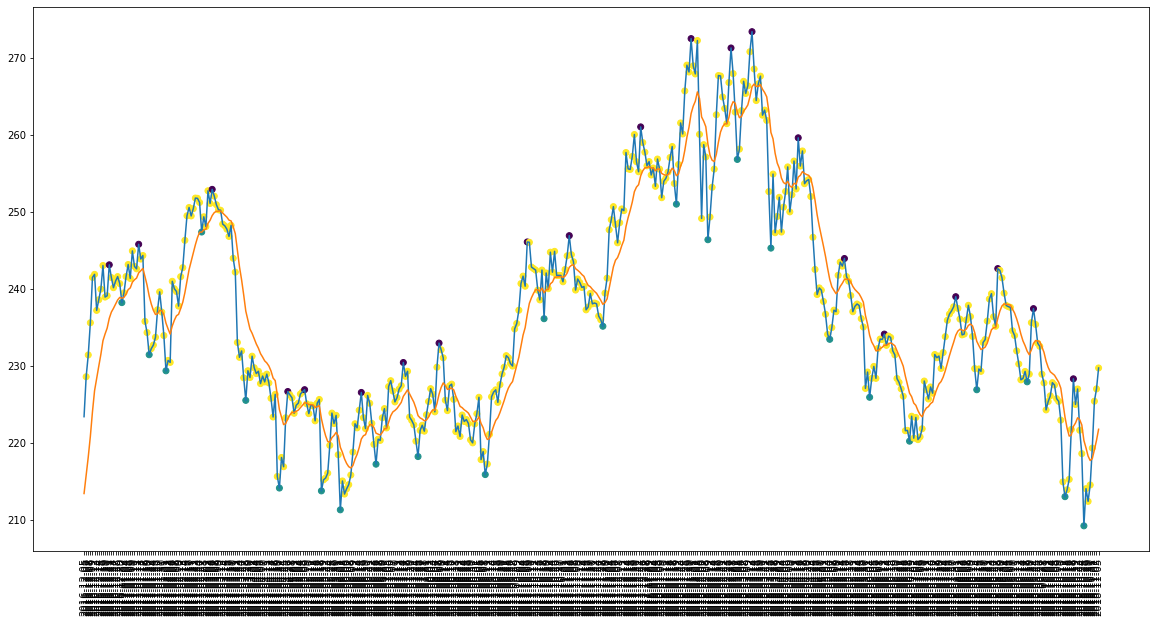

In [72]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [73]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1
        
# willr_data = np.array(willr_data)
# price_data = np.array(price_data)
# ema_data = np.array(ema_data)
# obv_data = np.array(obv_data)

In [74]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [76]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [77]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [78]:
model = tf.keras.models.load_model("models/bull_phase_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

15/15 [==============================] - 0s 5ms/step - loss: 0.1334 - accuracy: 0.7511 - mean_squared_error: 1.8846 - weighted_accuracy: 0.7511 - weighted_mean_squared_error: 1.8846
Test loss: 0.13337020576000214
Test accuracy: 0.7510638236999512


In [79]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 380, 1: 51, 0: 39})

In [80]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 426, 1: 24, 0: 20})

In [81]:
df = pd.read_csv("distribution phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [82]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [83]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2016-12-23,240.970001,237.434924,-26.807731,-247920400.0,2.0,2,2
2016-12-27,241.559998,237.978782,-26.032839,-245732900.0,2.0,2,2
2016-12-28,240.649994,238.529738,-26.433792,-243734700.0,2.0,2,2
2016-12-29,238.179993,238.855931,-48.235368,-246787700.0,1.0,2,1
2016-12-30,239.449997,238.751941,-72.451037,-249406700.0,2.0,1,2


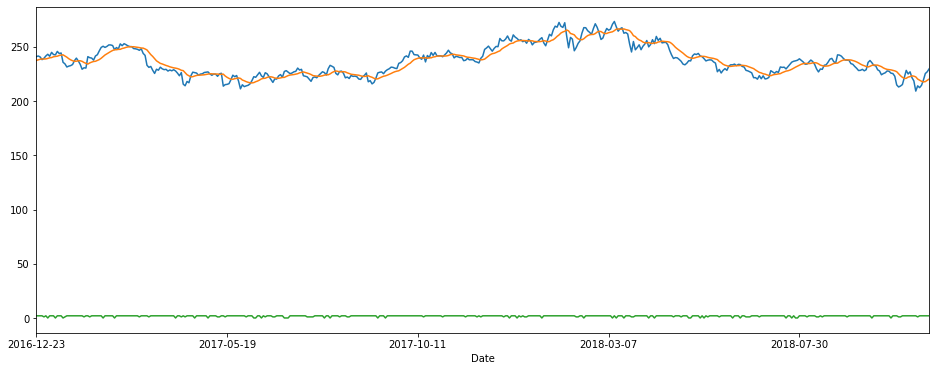

In [84]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

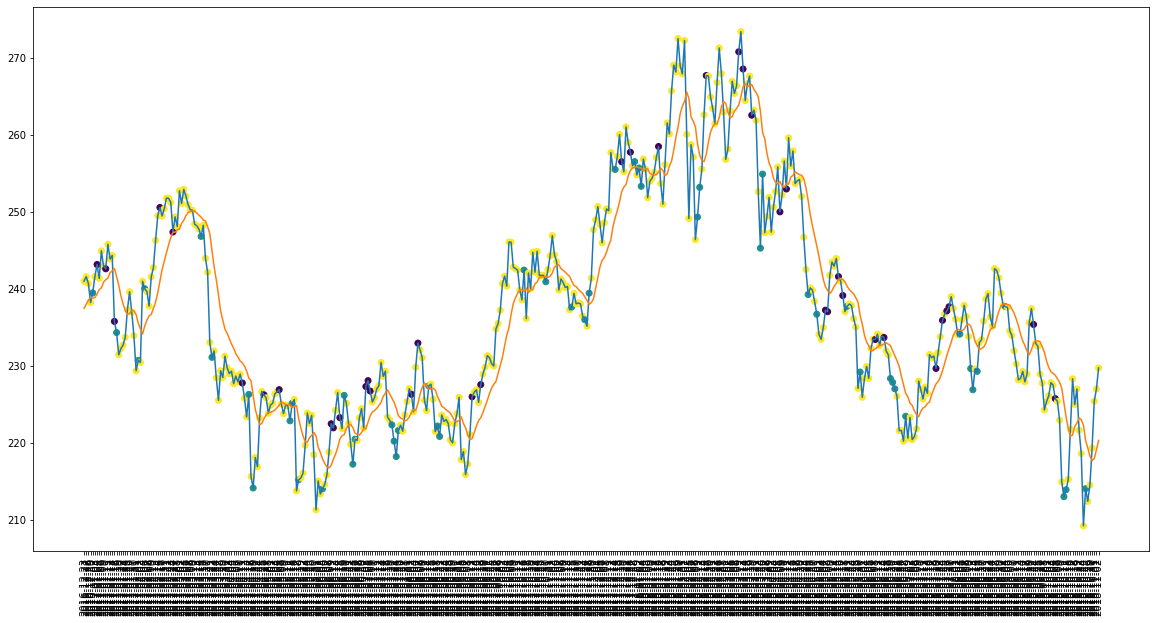

In [85]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

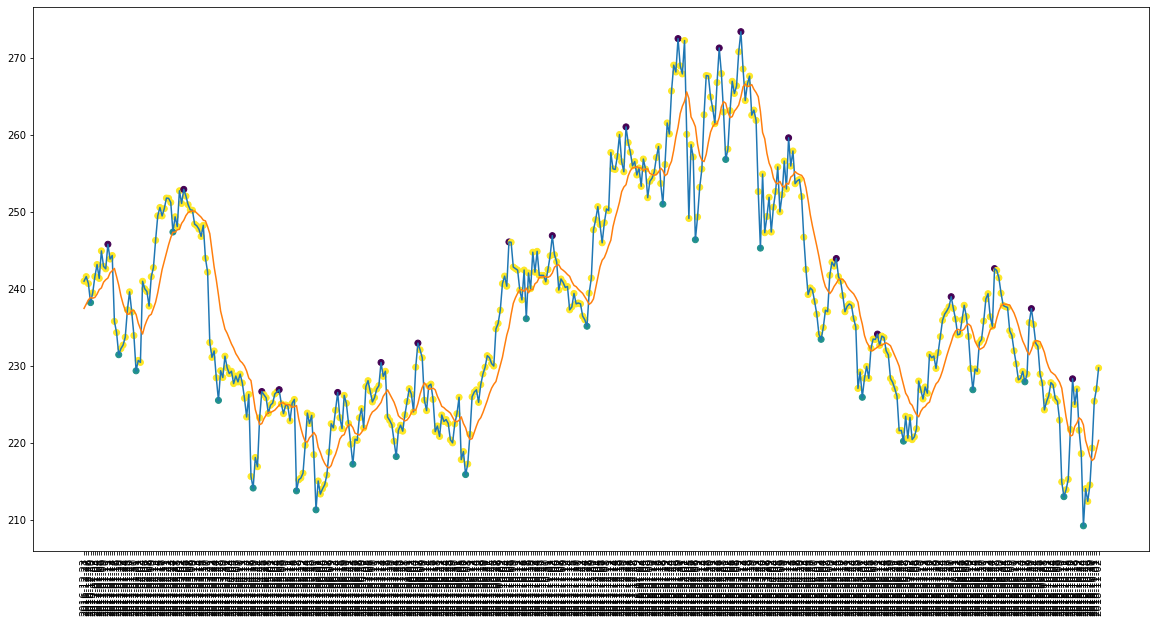

In [86]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [87]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 470
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 17
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 18
actual holds but predicted buy: 45
actual holds but predicted sell: 36
actual predicted holds: 345
Percentage buys correct: 25.0%
Percentage sells correct: 10.0%
Percentage holds correct: 80.98591549295774%
actual buys: 24
actual sells: 20
actual holds: 426


In [88]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[238.17999267578125, 239.4499969482422, 240.6499938964844, 240.97000122070312, 241.32000732421875, 241.55999755859366, 241.57000732421875, 243.1300048828125, 244.8999938964844]
[235.7400054931641, 241.32000732421875, 242.57000732421875, 242.88999938964844, 243.1300048828125, 243.83999633789062, 244.3000030517578, 244.8999938964844, 245.75999450683602]
Percentage buys correct: 64.70588235294117%
Percentage sells correct: 53.84615384615385%
Percentage holds correct: 84.69656992084433%


In [89]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $239.4499969482422
Shares owned at the moment: 41
Cash capital at the moment: $155.552137966155


Stop Loss Activated!

Share price: $231.41000366210938
Shares owned at the moment: 0
Cash capital at the moment: $9617.270810199736


Share price: $230.6699981689453
Shares owned at the moment: 41
Cash capital at the moment: $133.79284297943013


Price increase from previously bought: 8.31616586485624%
Share price: $250.5399932861328
Shares owned at the moment: 0
Cash capital at the moment: $10377.684183467863


Share price: $246.77999877929688
Shares owned at the moment: 41
Cash capital at the moment: $231.87978865432524


Stop Loss Activated!

Share price: $233.0
Shares owned at the moment: 0
Cash capital at the moment: $9758.609038654326


Share price: $231.07000732421875
Shares owned at the moment: 42
Cash capital at the moment: $26.980145191189877


Stop Loss Activated!

Share price: $223.32000732421875
Shares owned at the moment: 0
Cash capital at the moment: $9380.62699

In [90]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9484.453134635925
profit gained: -5.155468653640746%


In [91]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.782258,27.272727272727273%,0.0%,83.4061135371179%,42.857142857142854%,61.904761904761905%,83.41463414634147%,4.304738879795023%,8.344334352684001%
1,0.771689,28.571428571428573%,18.181818181818183%,82.08955223880596%,56.52173913043478%,58.8235294117647%,85.3932584269663%,-9.681691407947637%,25.65490331684112%
2,0.751064,25.0%,10.0%,80.98591549295774%,64.70588235294117%,53.84615384615385%,84.69656992084433%,-13.124945623359817%,-5.155468653640746%


### Mark Down Phase Test Data

In [92]:
logger = []

In [93]:
seed = 10
df = pd.read_csv("mark down phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2007-10-01   216.740005  205.638670  -5.220429  161688200.0     2.0
2007-10-02   222.979996  208.306567  -1.526716  171593800.0     2.0
2007-10-03   228.020004  211.339403  -1.071898  181013600.0     2.0
2007-10-04   227.350006  213.802573  -7.282412  170892200.0     2.0
2007-10-05   225.949997  215.671407 -10.566735  160852300.0     2.0


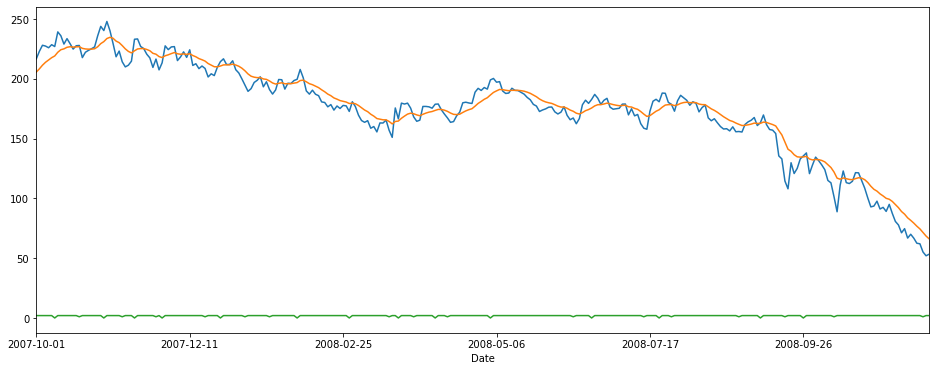

In [94]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

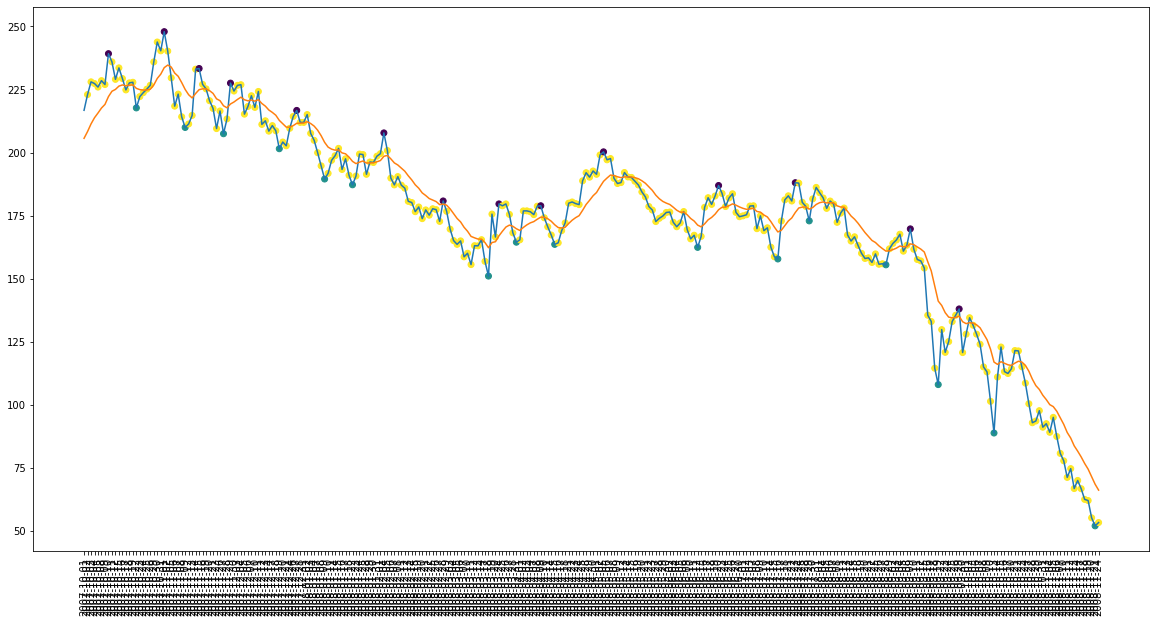

In [95]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [96]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [98]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [99]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [100]:
model = tf.keras.models.load_model("models/bull_phase_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

9/9 [==============================] - 0s 3ms/step - loss: 0.1302 - accuracy: 0.7590 - mean_squared_error: 1.8710 - weighted_accuracy: 0.7590 - weighted_mean_squared_error: 1.8710
Test loss: 0.13020113110542297
Test accuracy: 0.7589927911758423


In [101]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 223, 0: 19, 1: 36})

In [102]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 16, 2: 249, 0: 13})

In [103]:
df = pd.read_csv("mark down phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [104]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2007-10-19,217.690002,226.848008,-48.765388,164382100.0,1.0,2,1
2007-10-22,222.179993,225.439084,-99.592777,151275300.0,2.0,2,2
2007-10-23,223.759995,224.937685,-65.618001,163438800.0,2.0,2,2
2007-10-24,225.119995,224.756502,-59.700390,171615400.0,2.0,2,2
2007-10-25,226.660004,224.812424,-54.606755,184266200.0,2.0,2,2


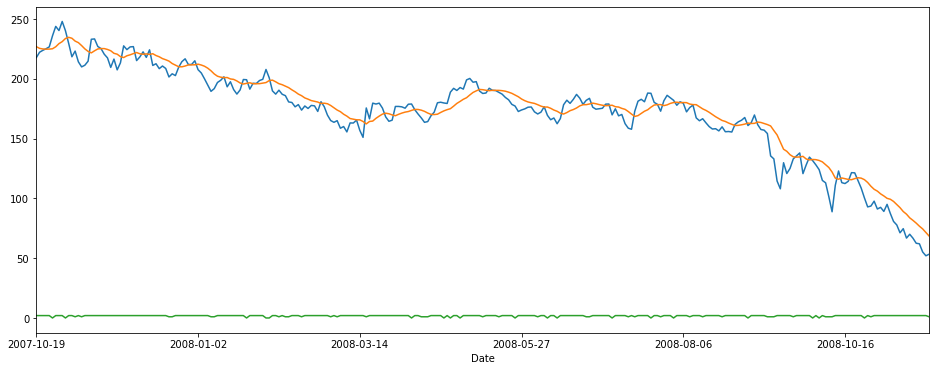

In [105]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

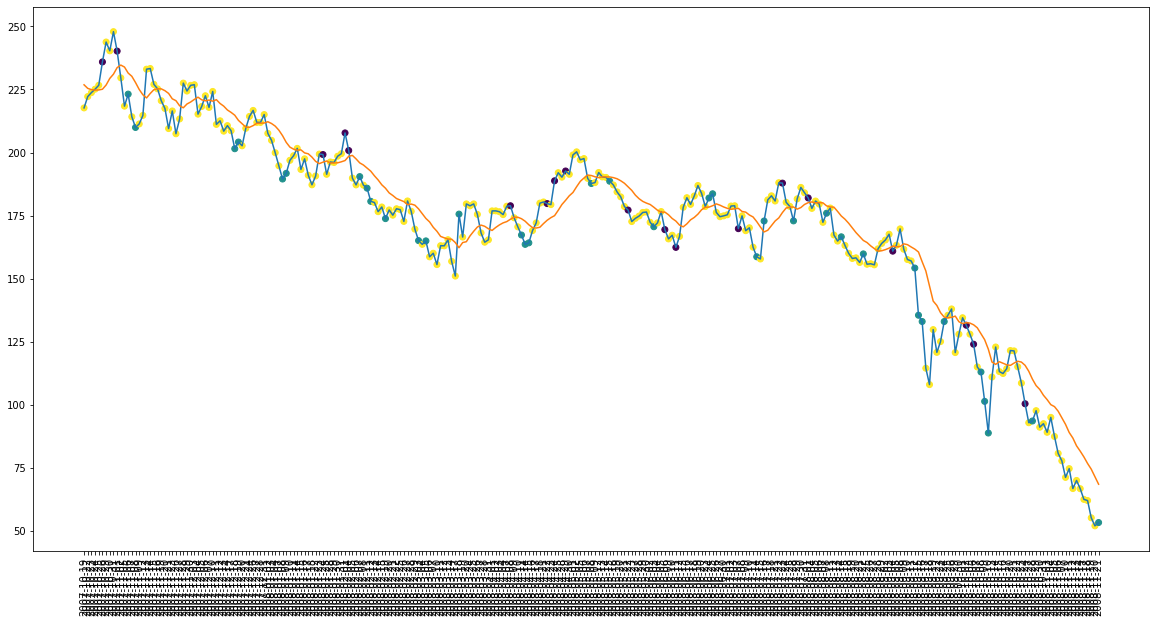

In [106]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

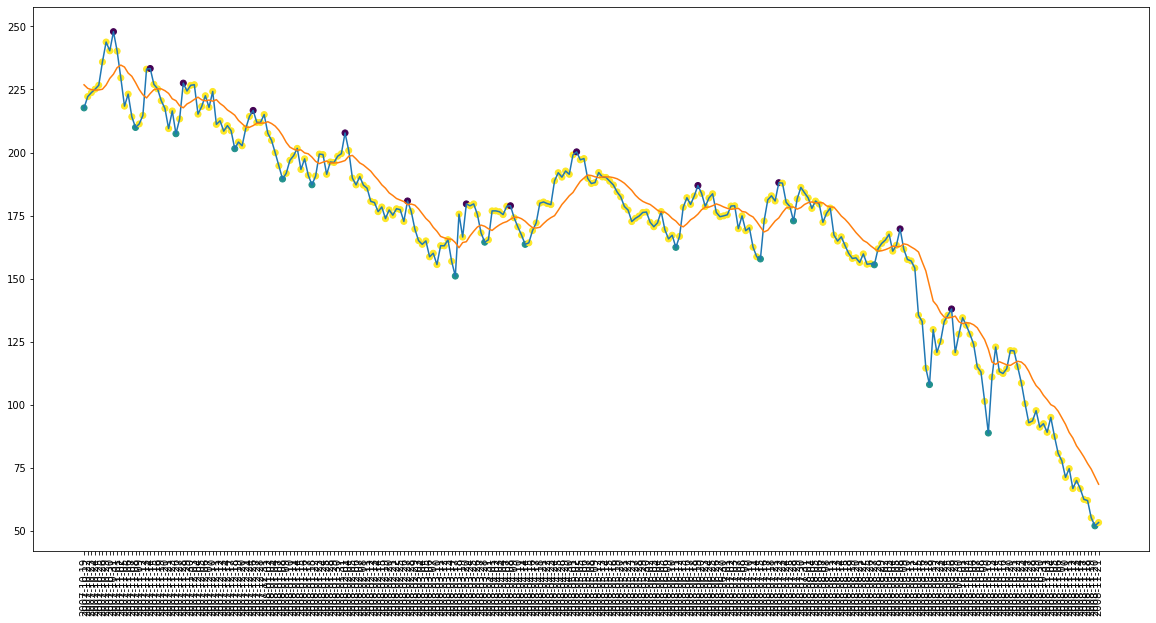

In [107]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [108]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 278
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 11
actual holds but predicted buy: 30
actual holds but predicted sell: 16
actual predicted holds: 203
Percentage buys correct: 37.5%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 81.52610441767068%
actual buys: 16
actual sells: 13
actual holds: 249


In [109]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[217.69000244140625, 222.17999267578125, 223.75999450683602, 225.1199951171875, 226.66000366210938, 235.9199981689453, 240.3300018310547, 243.80999755859366, 247.9199981689453]
[209.94000244140625, 214.17999267578125, 218.38999938964844, 223.16000366210938, 229.6000061035156, 240.2100067138672, 240.3300018310547, 243.80999755859366, 247.9199981689453]
Percentage buys correct: 47.22222222222222%
Percentage sells correct: 47.36842105263158%
Percentage holds correct: 84.23423423423424%


In [110]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $223.16000366210938
Shares owned at the moment: 44
Cash capital at the moment: $153.95747842407218


Stop Loss Activated!

Share price: $214.17999267578125
Shares owned at the moment: 0
Cash capital at the moment: $9551.961377044678


Share price: $209.94000244140625
Shares owned at the moment: 45
Cash capital at the moment: $78.68119187927186


Stop Loss Activated!

Share price: $201.50999450683602
Shares owned at the moment: 0
Cash capital at the moment: $9121.694082866672


Share price: $201.50999450683602
Shares owned at the moment: 45
Cash capital at the moment: $28.807468238830552


Stop Loss Activated!

Share price: $194.72999572753903
Shares owned at the moment: 0
Cash capital at the moment: $8767.559439006804


Share price: $189.5
Shares owned at the moment: 46
Cash capital at the moment: $26.587689006802975


Price increase from previously bought: 9.345736574971264%
Share price: $207.77999877929688
Shares owned at the moment: 0
Cash capital at the moment: $9558.1

In [111]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $2569.3637014627457
profit gained: -74.30636298537254%


In [112]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.782258,27.272727272727273%,0.0%,83.4061135371179%,42.857142857142854%,61.904761904761905%,83.41463414634147%,4.304738879795023%,8.344334352684001%
1,0.771689,28.571428571428573%,18.181818181818183%,82.08955223880596%,56.52173913043478%,58.8235294117647%,85.3932584269663%,-9.681691407947637%,25.65490331684112%
2,0.751064,25.0%,10.0%,80.98591549295774%,64.70588235294117%,53.84615384615385%,84.69656992084433%,-13.124945623359817%,-5.155468653640746%
3,0.758993,37.5%,15.384615384615385%,81.52610441767068%,47.22222222222222%,47.36842105263158%,84.23423423423424%,-59.6852373167802%,-74.30636298537254%


### bull phase test data

In [113]:
logger = []

In [114]:
seed = 10
df = pd.read_csv("bull phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


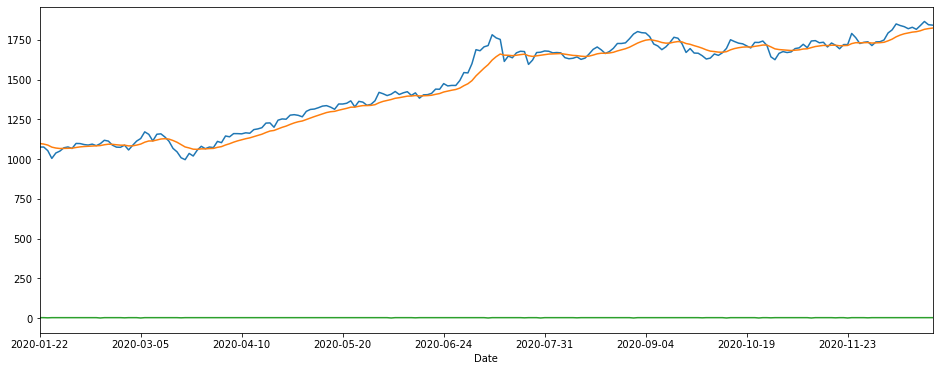

In [115]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [116]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/bull_phase_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1327 - accuracy: 0.7212 - mean_squared_error: 1.9608 - weighted_accuracy: 0.7212 - weighted_mean_squared_error: 1.9608
Test loss: 0.1327083855867386
Test accuracy: 0.7211538553237915


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 162, 0: 28, 1: 18})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [123]:
df = pd.read_csv("bull phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [124]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,0,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


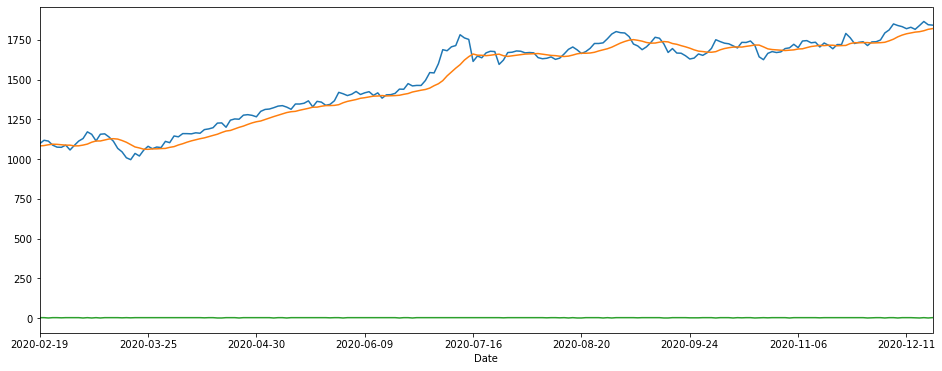

In [125]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

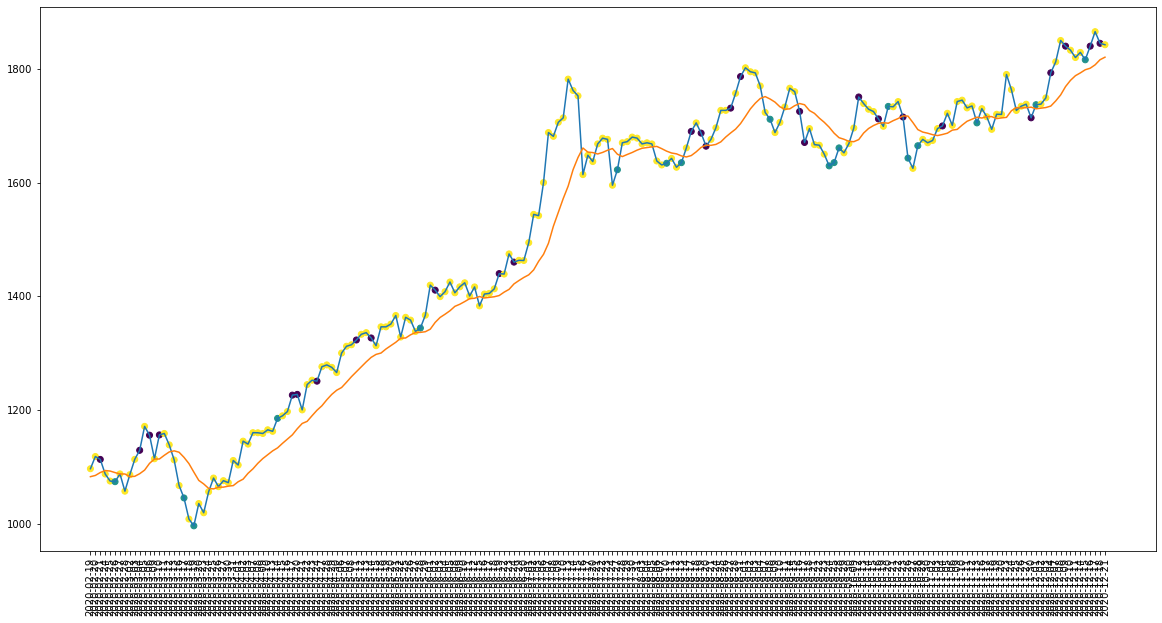

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

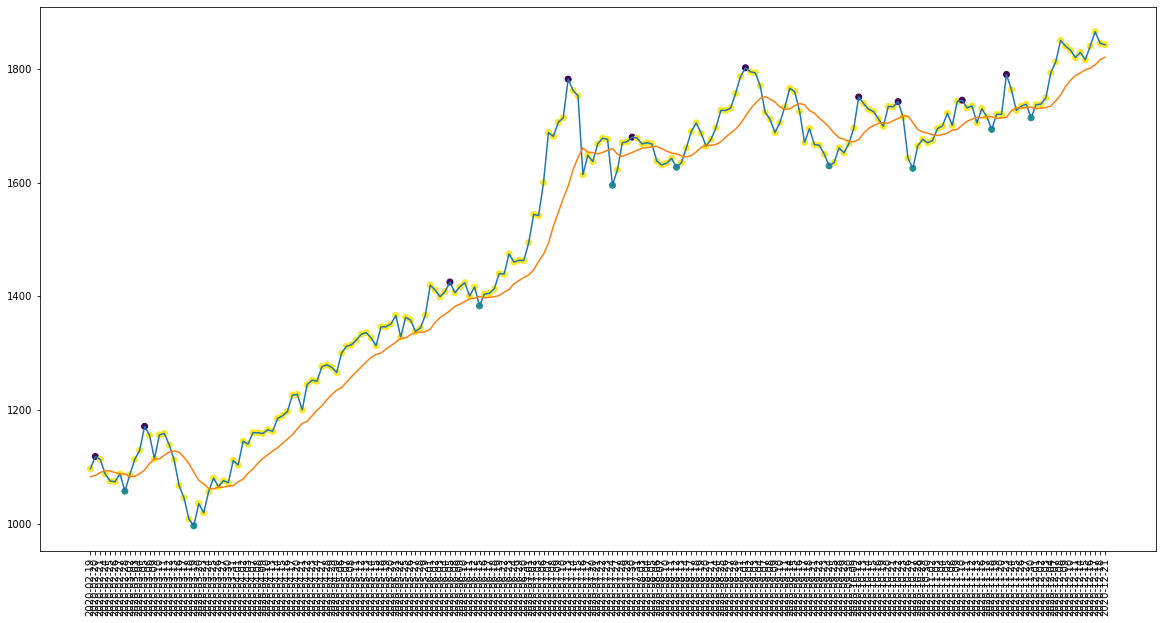

In [127]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [128]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 16
actual holds but predicted sell: 26
actual predicted holds: 147
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 10.0%
Percentage holds correct: 77.77777777777777%
actual buys: 9
actual sells: 10
actual holds: 189


In [129]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 77.77777777777777%
Percentage sells correct: 60.714285714285715%
Percentage holds correct: 83.85093167701864%


In [130]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1073.699951171875
Shares owned at the moment: 9
Cash capital at the moment: $310.1263656616211


Price increase from previously bought: 7.3233810103249475%
Share price: $1155.5
Shares owned at the moment: 0
Cash capital at the moment: $10681.02774066162


Share price: $1045.0999755859377
Shares owned at the moment: 10
Cash capital at the moment: $201.28773547363016


Stop Loss Activated!

Share price: $1007.989990234375
Shares owned at the moment: 0
Cash capital at the moment: $10253.467913085935


Share price: $996.0
Shares owned at the moment: 10
Cash capital at the moment: $266.0779130859355


Price increase from previously bought: 22.75479379497547%
Share price: $1226.0
Shares owned at the moment: 0
Cash capital at the moment: $12492.362913085935


Share price: $1344.0
Shares owned at the moment: 9
Cash capital at the moment: $363.0989130859343


Price increase from previously bought: 6.837147681696187%
Share price: $1439.8399658203125
Shares owned at the moment: 0
Ca

In [131]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


In [132]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.782258,27.272727272727273%,0.0%,83.4061135371179%,42.857142857142854%,61.904761904761905%,83.41463414634147%,4.304738879795023%,8.344334352684001%
1,0.771689,28.571428571428573%,18.181818181818183%,82.08955223880596%,56.52173913043478%,58.8235294117647%,85.3932584269663%,-9.681691407947637%,25.65490331684112%
2,0.751064,25.0%,10.0%,80.98591549295774%,64.70588235294117%,53.84615384615385%,84.69656992084433%,-13.124945623359817%,-5.155468653640746%
3,0.758993,37.5%,15.384615384615385%,81.52610441767068%,47.22222222222222%,47.36842105263158%,84.23423423423424%,-59.6852373167802%,-74.30636298537254%
4,0.721154,22.22222222222222%,10.0%,77.77777777777777%,77.77777777777777%,60.714285714285715%,83.85093167701864%,48.64919381744377%,66.41259749999998%


### bear phase data

In [133]:
logger = []

In [134]:
seed = 10
df = pd.read_csv("bear phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-01-22    32.830002  32.653718 -49.494874  128764966.0     2.0
2018-01-23    33.750000  32.822377 -18.518497  165063463.0     2.0
2018-01-24    33.970001  32.998934 -16.190425  201240854.0     2.0
2018-01-25    33.959999  33.146790 -17.627141  173336178.0     2.0
2018-01-26    34.880001  33.413438  -2.648942  221767625.0     0.0


In [135]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [137]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [138]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [139]:
model = tf.keras.models.load_model("models/bull_phase_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

19/19 [==============================] - 0s 5ms/step - loss: 0.1358 - accuracy: 0.7345 - mean_squared_error: 1.8744 - weighted_accuracy: 0.7345 - weighted_mean_squared_error: 1.8744
Test loss: 0.13583025336265564
Test accuracy: 0.7344537973403931


In [140]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 61, 2: 482, 0: 52})

In [141]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [142]:
df = pd.read_csv("bear phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [143]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2018-02-09,32.009998,33.951521,-90.236635,104835489.0,1.0,1,1
2018-02-12,32.320000,33.652826,-74.280269,68354718.0,2.0,1,2
2018-02-13,32.919998,33.447775,-68.330148,85359125.0,2.0,2,2
2018-02-14,33.209999,33.366579,-56.813864,101567392.0,2.0,2,2
2018-02-22,34.020000,33.342490,-51.247629,113719002.0,2.0,2,2


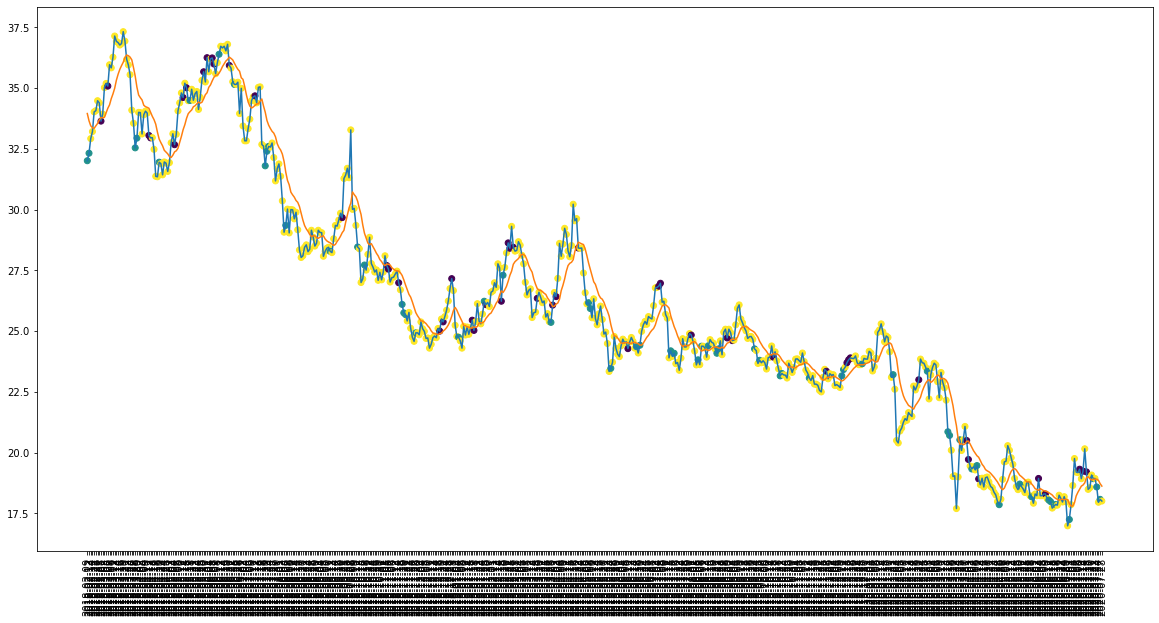

In [144]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

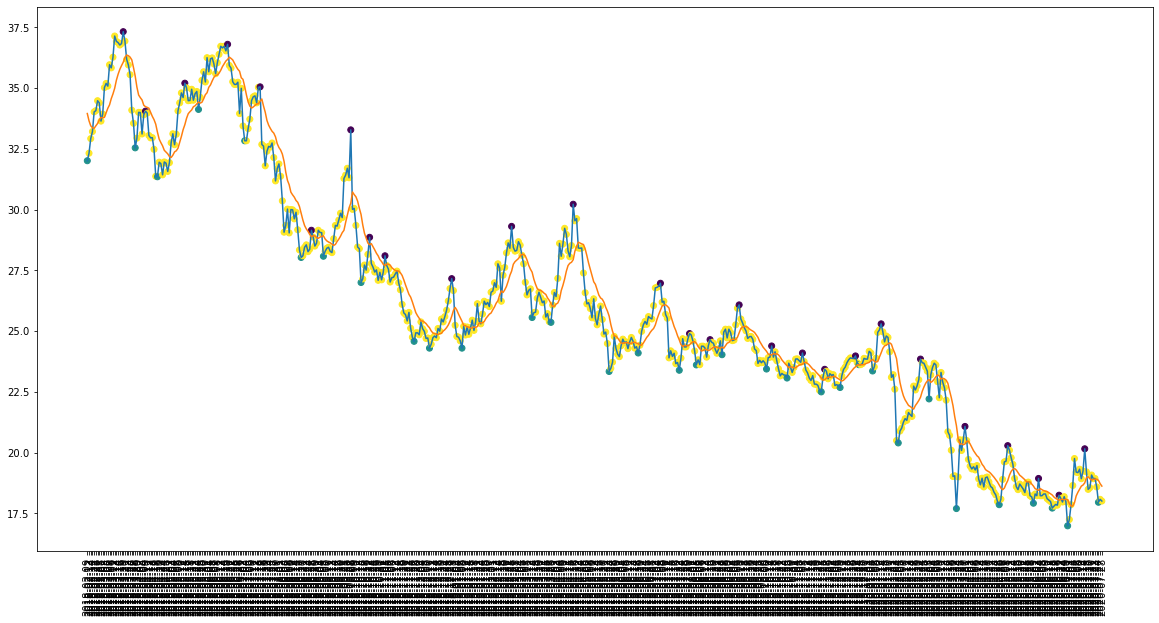

In [145]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [146]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 595
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 28
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 24
actual holds but predicted buy: 57
actual holds but predicted sell: 49
actual predicted holds: 430
Percentage buys correct: 12.5%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 80.22388059701493%
actual buys: 32
actual sells: 27
actual holds: 536


In [147]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[32.009998321533196, 32.31999969482422, 32.919998168945305, 33.209999084472656, 33.639999389648445, 34.02000045776367, 34.06999969482422, 34.389999389648445, 34.47999954223633]
[33.639999389648445, 33.93000030517578, 34.389999389648445, 34.47999954223633, 35.02000045776367, 35.080001831054695, 35.189998626708984, 35.83000183105469, 35.959999084472656]
Percentage buys correct: 55.73770491803279%
Percentage sells correct: 50.0%
Percentage holds correct: 82.32848232848232%


In [148]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $32.009998321533196
Shares owned at the moment: 311
Cash capital at the moment: $17.513970938683997


Price increase from previously bought: 9.290216261729146%
Share price: $35.080001831054695
Shares owned at the moment: 0
Cash capital at the moment: $10897.392368830684


Share price: $32.540000915527344
Shares owned at the moment: 333
Cash capital at the moment: $31.77355812168389


Stop Loss Activated!

Share price: $31.3700008392334
Shares owned at the moment: 0
Cash capital at the moment: $10449.256759317877


Share price: $31.95000076293945
Shares owned at the moment: 326
Cash capital at the moment: $4.913334915641826


Price increase from previously bought: 8.028429748999377%
Share price: $34.610000610351555
Shares owned at the moment: 0
Cash capital at the moment: $11256.745668343068


Share price: $34.490001678466804
Shares owned at the moment: 325
Cash capital at the moment: $16.669683841228107


Stop Loss Activated!

Share price: $33.439998626708984
Shares owned 

In [149]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5603.220989425184
profit gained: -43.967790105748165%


In [150]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.782258,27.272727272727273%,0.0%,83.4061135371179%,42.857142857142854%,61.904761904761905%,83.41463414634147%,4.304738879795023%,8.344334352684001%
1,0.771689,28.571428571428573%,18.181818181818183%,82.08955223880596%,56.52173913043478%,58.8235294117647%,85.3932584269663%,-9.681691407947637%,25.65490331684112%
2,0.751064,25.0%,10.0%,80.98591549295774%,64.70588235294117%,53.84615384615385%,84.69656992084433%,-13.124945623359817%,-5.155468653640746%
3,0.758993,37.5%,15.384615384615385%,81.52610441767068%,47.22222222222222%,47.36842105263158%,84.23423423423424%,-59.6852373167802%,-74.30636298537254%
4,0.721154,22.22222222222222%,10.0%,77.77777777777777%,77.77777777777777%,60.714285714285715%,83.85093167701864%,48.64919381744377%,66.41259749999998%
5,0.734454,12.5%,11.11111111111111%,80.22388059701493%,55.73770491803279%,50.0%,82.32848232848232%,-22.184703546414447%,-43.967790105748165%


### Full Cycle Test Data

In [151]:
logger = []

In [152]:
seed = 10
df = pd.read_csv("full cycle data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2002-11-11         8.74  8.763110 -71.929852 -553467352.0     2.0
2002-11-12         8.50  8.722632 -80.487816 -559735252.0     2.0
2002-11-13         8.63  8.708381 -69.918697 -552295352.0     2.0
2002-11-14         8.52  8.679399 -78.861762 -566378552.0     2.0
2002-11-15         8.80  8.697953 -56.097548 -558353452.0     2.0


In [153]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [155]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [156]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [157]:
model = tf.keras.models.load_model("models/bull_phase_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

29/29 [==============================] - 0s 7ms/step - loss: 0.1333 - accuracy: 0.7186 - mean_squared_error: 1.8776 - weighted_accuracy: 0.7186 - weighted_mean_squared_error: 1.8776
Test loss: 0.133265420794487
Test accuracy: 0.7186477780342102


In [158]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 717, 0: 98, 1: 102})

In [159]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [160]:
df = pd.read_csv("full cycle data/test_data.csv")
df.set_index('Date', inplace=True)

In [161]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2002-12-02,11.45,10.087284,-3.883491,-531653852.0,0.0,2,0
2002-12-03,9.96,10.296932,-13.142858,-519461852.0,2.0,2,2
2002-12-04,10.15,10.245097,-55.714280,-548693152.0,2.0,2,2
2002-12-05,10.02,10.230466,-51.764718,-529235552.0,2.0,2,2
2002-12-06,9.88,10.198087,-55.588224,-540995752.0,2.0,2,2


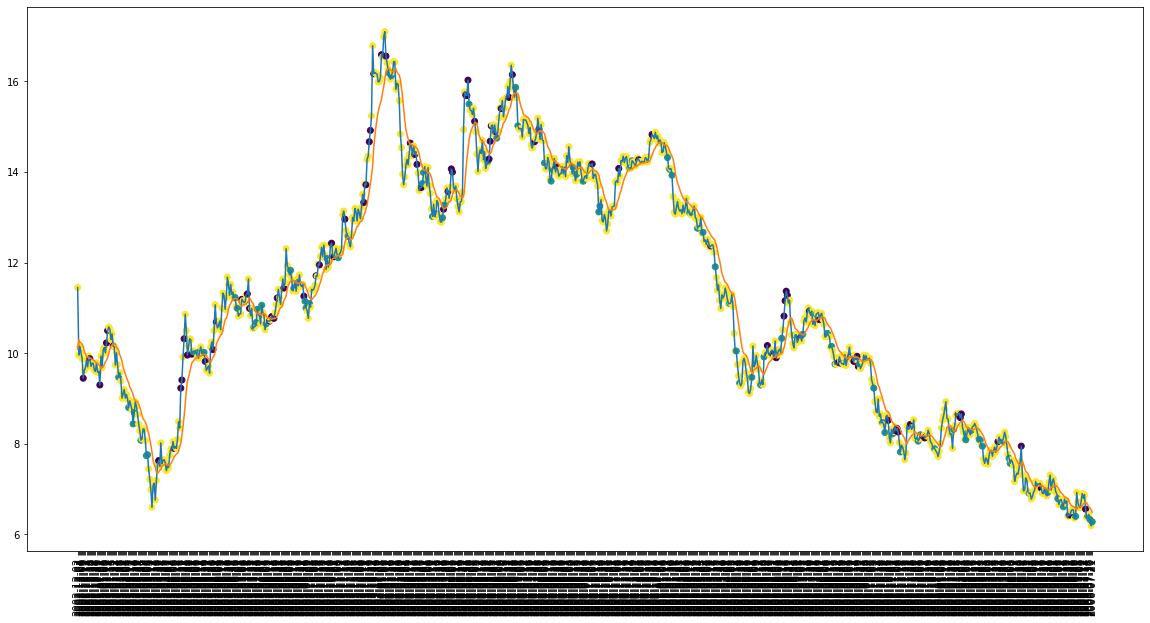

In [162]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

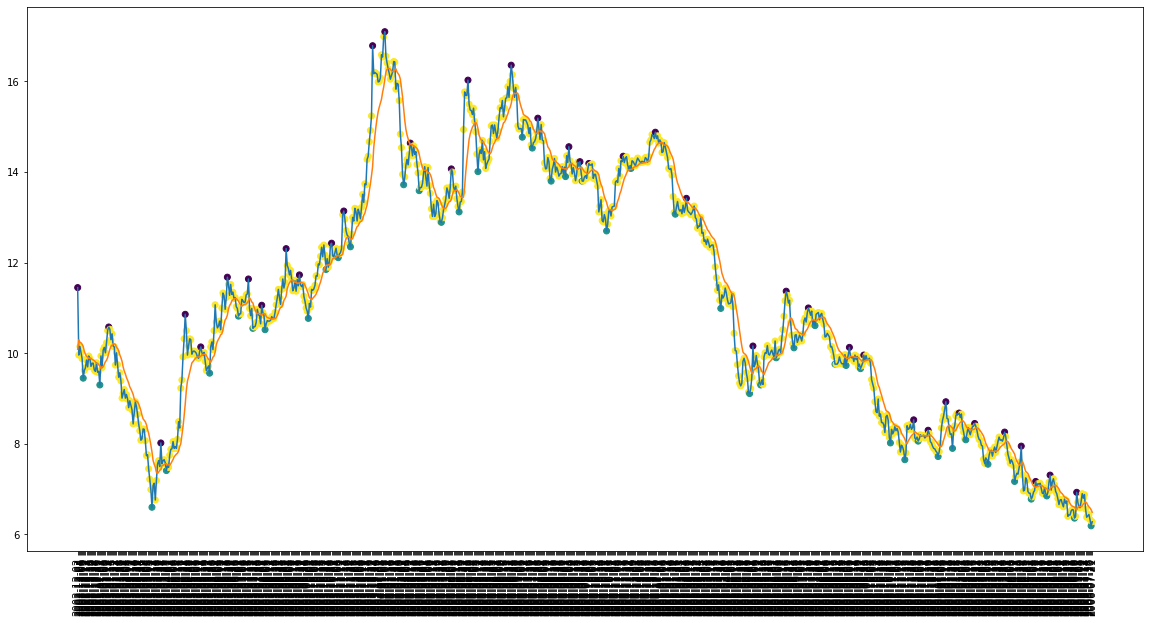

In [163]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [164]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 917
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 37
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 33
actual holds but predicted buy: 95
actual holds but predicted sell: 89
actual predicted holds: 647
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 15.0%
Percentage holds correct: 77.85800240673886%
actual buys: 46
actual sells: 40
actual holds: 831


In [165]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[9.449999809265137, 9.619999885559082, 9.68000030517578, 9.850000381469727, 9.880000114440918, 9.960000038146973, 10.020000457763672, 10.149999618530273, 11.449999809265135]
[9.619999885559082, 9.68000030517578, 9.699999809265137, 9.710000038146973, 9.779999732971193, 9.779999732971193, 9.850000381469727, 9.880000114440918, 9.9399995803833]
Percentage buys correct: 54.90196078431372%
Percentage sells correct: 47.95918367346939%
Percentage holds correct: 83.24022346368714%


In [166]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.470000267028807
Shares owned at the moment: 1053
Cash capital at the moment: $0.6669655454170424


Stop Loss Activated!

Share price: $9.010000228881836
Shares owned at the moment: 0
Cash capital at the moment: $9462.106498395206


Share price: $8.800000190734863
Shares owned at the moment: 1072
Cash capital at the moment: $2.563893365146214


Stop Loss Activated!

Share price: $8.439999580383299
Shares owned at the moment: 0
Cash capital at the moment: $9025.362324773072


Share price: $8.439999580383299
Shares owned at the moment: 1066
Cash capital at the moment: $3.5809133145812666


Stop Loss Activated!

Share price: $8.079999923706055
Shares owned at the moment: 0
Cash capital at the moment: $8593.17431220889


Share price: $8.079999923706055
Shares owned at the moment: 1060
Cash capital at the moment: $4.821193302868778


Stop Loss Activated!

Share price: $7.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8186.658851355313


Share price

In [167]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5459.681323426963
profit gained: -45.40318676573037%


In [168]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.782258,27.272727272727273%,0.0%,83.4061135371179%,42.857142857142854%,61.904761904761905%,83.41463414634147%,4.304738879795023%,8.344334352684001%
1,0.771689,28.571428571428573%,18.181818181818183%,82.08955223880596%,56.52173913043478%,58.8235294117647%,85.3932584269663%,-9.681691407947637%,25.65490331684112%
2,0.751064,25.0%,10.0%,80.98591549295774%,64.70588235294117%,53.84615384615385%,84.69656992084433%,-13.124945623359817%,-5.155468653640746%
3,0.758993,37.5%,15.384615384615385%,81.52610441767068%,47.22222222222222%,47.36842105263158%,84.23423423423424%,-59.6852373167802%,-74.30636298537254%
4,0.721154,22.22222222222222%,10.0%,77.77777777777777%,77.77777777777777%,60.714285714285715%,83.85093167701864%,48.64919381744377%,66.41259749999998%
5,0.734454,12.5%,11.11111111111111%,80.22388059701493%,55.73770491803279%,50.0%,82.32848232848232%,-22.184703546414447%,-43.967790105748165%
6,0.718648,13.043478260869565%,15.0%,77.85800240673886%,54.90196078431372%,47.95918367346939%,83.24022346368714%,-59.7558339263739%,-45.40318676573037%


In [169]:
experiment

'bull phase CNN Images Experiment'

In [170]:
log.to_csv('{}.csv'.format(experiment))